# Support Vector Machine

## Homework #5 by Glaktionova Natalia

BNP Paribas Cardif

## Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

Считываем и просматриваем данные

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN




Изучаем структуру данных. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float64(108), int64(6), object(19)
memory usage: 107.7+ MB


Посмотрим на пропущенные значения и удалим столбец ID

In [4]:
df.drop(columns=['ID'], inplace=True)

In [5]:
missing = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending = False)

In [6]:
missing[missing > 40]

v30     52.580016
v113    48.376064
v102    44.887641
v85     44.333062
v119    44.331313
          ...    
v63     42.528494
v89     42.528494
v25     42.528494
v124    42.528494
v54     42.528494
Length: 102, dtype: float64

Посмотрим на целевую переменную

In [7]:
df.target.value_counts()

1    87021
0    27300
Name: target, dtype: int64

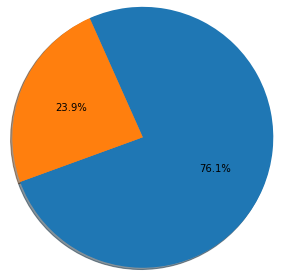

In [8]:
plt.pie(df.target.value_counts(), radius = 1.5, autopct='%1.1f%%', shadow=True,startangle=200);

## EDA

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier

In [10]:
def data_split_train_test(data, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=test_size,
    stratify=data['target'],
    random_state=0)

    print("Train_shape:", X_train.shape, "Test shape:", X_test.shape)
    
    return X_train, X_test, y_train, y_test

In [11]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    return X_train_scaled, X_test_scaled

In [12]:
def dataframe_metrics(actual,prediction):
    stats = [
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual),
        roc_auc_score(prediction, actual)
    ]
    return stats

In [13]:
#object_vars = list(df.select_dtypes(include=["object"]).columns)
num_vars = list(df.select_dtypes(exclude=["object"]).columns)

В работу возьмем цифровые признаки

In [14]:
data_num = df[num_vars].copy()

In [15]:
data_num.dropna(inplace=True)

In [16]:
Corr = data_num.corr()

In [17]:
corr_stack = (Corr.where(np.triu(np.ones(Corr.shape), k = 1)
                        .astype(np.bool))
                        .stack()
                        .sort_values(ascending=False))

In [18]:
corr_stack[abs(corr_stack) > 0.85]

v17  v76     0.992708
v46  v63     0.991746
v17  v64     0.982760
v25  v46     0.982468
     v63     0.981437
               ...   
v48  v64    -0.964873
v40  v114   -0.967394
v48  v106   -0.982841
v69  v115   -0.993674
v58  v100   -0.997667
Length: 90, dtype: float64

In [19]:
selected_columns = corr_stack[abs(corr_stack) > 0.85].index.tolist()
selected_columns = np.unique(np.asarray(selected_columns).ravel())
selected_columns

array(['v1', 'v10', 'v100', 'v103', 'v104', 'v105', 'v106', 'v108',
       'v109', 'v11', 'v111', 'v114', 'v115', 'v116', 'v118', 'v12',
       'v121', 'v124', 'v128', 'v13', 'v130', 'v15', 'v17', 'v20', 'v25',
       'v26', 'v29', 'v32', 'v33', 'v34', 'v37', 'v39', 'v40', 'v41',
       'v43', 'v44', 'v46', 'v48', 'v49', 'v5', 'v53', 'v54', 'v55',
       'v58', 'v60', 'v61', 'v63', 'v64', 'v65', 'v67', 'v68', 'v69',
       'v73', 'v76', 'v77', 'v8', 'v81', 'v83', 'v86', 'v89', 'v92',
       'v93', 'v94', 'v95', 'v96', 'v97'], dtype='<U4')

Убираем столбцы с сильной корреляцией

In [20]:
data_num = data_num.drop(columns=selected_columns)

In [21]:
data_num.head()

,target,v2,v4,v6,v7,v9,v14,v16,v18,v19,...,v102,v117,v119,v120,v122,v123,v126,v127,v129,v131
0,1,8.727474,3.921026,2.599278,3.176895,9.999999,11.636387,8.571429,0.106720,0.148883,...,2.757375,6.592012,-6.297423e-07,1.059603,8.000000,1.989780,1.804126,3.113719,0,2.857144
2,1,5.310079,4.410969,3.979592,3.928571,12.666667,9.603542,5.882353,0.244541,0.144258,...,3.292788,3.478911,-2.792745e-07,2.138728,9.333333,2.477596,1.773709,3.922193,2,1.176472
3,1,8.304757,4.225930,2.097700,1.987549,8.965516,14.094723,5.517242,1.224114,0.231630,...,2.503055,4.949609,5.655086e-01,1.166281,7.018256,1.812795,1.415230,2.954381,1,1.034483
6,0,7.312995,3.494148,1.926070,1.770427,5.011287,12.148604,6.601941,0.484133,0.443661,...,2.511898,12.168719,1.532727e+00,0.846716,3.476299,1.992594,3.276100,1.623298,0,0.970873
8,0,8.462619,3.739030,1.573033,2.303371,11.111111,12.603403,6.666667,0.139939,0.180616,...,1.780246,3.419186,5.182423e-01,1.414142,8.148148,1.875560,1.159637,5.582865,0,3.333334


In [22]:
data_num = data_num.sample(n=10000, replace=False)

In [23]:
data_num.shape

(10000, 47)

In [24]:
X_train, X_test, y_train, y_test = data_split_train_test(data_num)

Train_shape: (7000, 46) Test shape: (3000, 46)


In [25]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

## Baseline

In [26]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train_scaled, y_train)
pred_dummy = dummy_clf.predict(X_test_scaled)

In [27]:
measured_metrics = pd.DataFrame({"error_type":["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]})

In [28]:
measured_metrics["baseline"] = dataframe_metrics(y_test, pred_dummy)
measured_metrics

,error_type,baseline
0,Accuracy,0.635000
1,Precision,0.756055
2,Recall,0.760407
3,F1,0.758225
4,ROC-AUC,0.506888


**Logistic Regression**

In [29]:
model_LogR = LogisticRegression(max_iter=2000, solver='lbfgs')
model_LogR.fit(X_train_scaled, y_train)
pred = model_LogR.predict(X_test_scaled)

In [30]:
measured_metrics["LogReg"] = dataframe_metrics(y_test, pred)
measured_metrics

,error_type,baseline,LogReg
0,Accuracy,0.635000,0.756000
1,Precision,0.756055,0.996477
2,Recall,0.760407,0.757616
3,F1,0.758225,0.860784
4,ROC-AUC,0.506888,0.571116


**KNN**

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

In [32]:
param_grid = {
    'n_neighbors': range(1, 50),
    'p': range(1, 4)
}

knn = KNeighborsClassifier()

rand_search = RandomizedSearchCV(knn, param_grid, cv=5, scoring='f1', random_state=40, n_jobs=-1)
rand_search.fit(X_train_scaled, y_train)

print("Best CV score: {:.3f}, best CV k: {}".format(
    rand_search.best_score_, rand_search.best_estimator_.n_neighbors)
)

Best CV score: 0.861, best CV k: 45


In [33]:
pred_KNN = rand_search.predict(X_test_scaled)

In [34]:
measured_metrics["KNN"] = dataframe_metrics(y_test, pred_KNN)
measured_metrics

,error_type,baseline,LogReg,KNN
0,Accuracy,0.635000,0.756000,0.756667
1,Precision,0.756055,0.996477,0.998239
2,Recall,0.760407,0.757616,0.757434
3,F1,0.758225,0.860784,0.861322
4,ROC-AUC,0.506888,0.571116,0.593003


**SVM**

In [51]:
from sklearn import svm
from sklearn.model_selection import StratifiedKFold

In [53]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
classes = ['balanced']

param_svc_grid = {
    'C': Cs,
    'gamma' : gammas,
    'class_weight' : classes
}

svc = svm.SVC()

svc_search = RandomizedSearchCV(svc, param_svc_grid, scoring='roc_auc', cv = StratifiedKFold(5), n_jobs=-1)
svc_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'class_weight': ['balanced'],
                                        'gamma': [0.001, 0.01, 0.1, 1]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [54]:
svc_search.best_estimator_

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [55]:
pred_svc = svc_search.predict(X_test_scaled)

In [56]:
measured_metrics["SVM"] = dataframe_metrics(y_test, pred_svc)
measured_metrics

,error_type,baseline,LogReg,KNN,SVM
0,Accuracy,0.635000,0.756000,0.756667,0.585667
1,Precision,0.756055,0.996477,0.998239,0.546015
2,Recall,0.760407,0.757616,0.757434,0.853994
3,F1,0.758225,0.860784,0.861322,0.666129
4,ROC-AUC,0.506888,0.571116,0.593003,0.593987
